# Aprendizagem por reforço

## Descrição do ambiente

**sequential_decision_environment** está descrito na figura 17.1 do livro-texto.

In [4]:
from mdp import sequential_decision_environment

## Agente MDP

Resultados do <i>Value Iteration</i> para o ambiente em questão.

In [5]:
from mdp import value_iteration
print(value_iteration(sequential_decision_environment))

{(0, 1): 0.3984432178350045, (1, 2): 0.649585681261095, (2, 1): 0.48644001739269643, (0, 0): 0.2962883154554812, (3, 1): -1.0, (2, 0): 0.3447542300124158, (3, 0): 0.12987274656746342, (0, 2): 0.5093943765842497, (2, 2): 0.7953620878466678, (1, 0): 0.25386699846479516, (3, 2): 1.0}


## Agente Q-Learning

Método livre de modelo. Aprende-se uma função Q(s, a) que retorna a utilidade (recompensa) de se tomar uma determinada ação a a partir de um estado particular s.

In [6]:
from collections import defaultdict
from utils import argmax
from mdp import MDP, policy_evaluation

import random


class QLearningAgent:
    """ An exploratory Q-learning agent. It avoids having to learn the transition
        model because the Q-value of a state can be related directly to those of
        its neighbors. [Figure 21.8]
    """
    def __init__(self, mdp, Ne, Rplus, alpha=None):

        self.gamma = mdp.gamma
        self.terminals = mdp.terminals
        self.all_act = mdp.actlist
        self.Ne = Ne  # iteration limit in exploration function
        self.Rplus = Rplus  # large value to assign before iteration limit
        self.Q = defaultdict(float)
        self.Nsa = defaultdict(float)
        self.s = None
        self.a = None
        self.r = None

        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1./(1+n)  # udacity video

    def f(self, u, n):
        """ Exploration function. Returns fixed Rplus untill
        agent has visited state, action a Ne number of times.
        Same as ADP agent in book."""
        if n < self.Ne:
            return self.Rplus
        else:
            return u

    def actions_in_state(self, state):
        """ Returns actions possible in given state.
            Useful for max and argmax. """
        if state in self.terminals:
            return [None]
        else:
            return self.all_act

    def __call__(self, percept):
        s1, r1 = self.update_state(percept)
        Q, Nsa, s, a, r = self.Q, self.Nsa, self.s, self.a, self.r
        alpha, gamma, terminals, actions_in_state = self.alpha, self.gamma, self.terminals, self.actions_in_state
        if s1 in terminals:
            Q[s1, None] = r1
        if s is not None:
            Nsa[s, a] += 1
            Q[s, a] += alpha(Nsa[s, a]) * (r + gamma * max(Q[s1, a1] for a1 in actions_in_state(s1))
                                             - Q[s, a])
        if s1 in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.r = s1, r1
            self.a = argmax(actions_in_state(s1), key=lambda a1: self.f(Q[s1, a1], Nsa[s1, a1]))
        return self.a

    def update_state(self, percept):
        ''' To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)'''
        return percept


def run_single_trial(agent_program, mdp):
    ''' Execute trial for given agent_program
    and mdp. mdp should be an instance of subclass
    of mdp.MDP '''

    def take_single_action(mdp, s, a):
        '''
        Selects outcome of taking action a
        in state s. Weighted Sampling.
        '''
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in mdp.T(s, a):
            probability, state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        return state

    current_state = mdp.init
    while True:
        current_reward = mdp.R(current_state)
        percept = (current_state, current_reward)
        next_action = agent_program(percept)
        if next_action is None:
            break
        current_state = take_single_action(mdp, current_state, next_action)

Fator de desconto **gamma = 0.9**. Função de exploração (exploration) **f** que retorna **Rplus** fixa até o limite de **Ne** número de vezes (veja pg **842** do livro). O método **actions_in_state** retorna ações possíveis num dado estado. O valor de **alpha** está definido no rodapé da página 837. Valores de **Rplus** e **Ne** são os definidos na página 843 (Fig 21.7).

In [7]:
q_agent = QLearningAgent(sequential_decision_environment, Ne=5, Rplus=2, 
                         alpha=lambda n: 60./(59+n))


Executando o q_agent por **500** iterações e mostrando os Q-Values gerados. As chaves são pares estado-ação. As ações são: norte = (0, 1), sul = (0,-1), oeste = (-1, 0) e leste = (1, 0).

In [8]:
for i in range(500):
    run_single_trial(q_agent,sequential_decision_environment)
q_agent.Q

defaultdict(float,
            {((0, 0), (1, 0)): 0.029353122943482867,
             ((0, 0), (0, 1)): -0.12605389383062632,
             ((0, 0), (-1, 0)): -0.12953971401732597,
             ((0, 0), (0, -1)): -0.12811188414969485,
             ((1, 0), (1, 0)): 0.002078389016784887,
             ((1, 0), (0, 1)): -0.10312830387795988,
             ((1, 0), (-1, 0)): -0.1033112255275132,
             ((1, 0), (0, -1)): -0.12631814957654425,
             ((2, 0), (1, 0)): -0.1502201568303818,
             ((2, 0), (0, 1)): 0.025943548719895376,
             ((2, 0), (-1, 0)): -0.15003320350032823,
             ((2, 0), (0, -1)): -0.13255775028778732,
             ((3, 0), (1, 0)): -0.3382861488997598,
             ((3, 0), (0, 1)): -0.9399985835159025,
             ((3, 0), (-1, 0)): -0.5252065109211145,
             ((3, 0), (0, -1)): -0.12526820046134143,
             ((3, 1), None): -1,
             ((2, 1), (1, 0)): -0.9400000000000001,
             ((2, 1), (0, 1)): -0.81496477233

A utilidade (recompensa) **U** de cada estado está relacionada à **Q** pela seguinte equação: **U (s) = max <sub>a</sub> Q(s, a)**. <br>Convertendo então Q-values em estimativas U...

In [9]:
U = defaultdict(lambda: -1000.) # Very Large Negative Value for Comparison see below.
for state_action, value in q_agent.Q.items():
    state, action = state_action
    if U[state] < value:
        U[state] = value
U

defaultdict(<function __main__.<lambda>()>,
            {(0, 0): 0.029353122943482867,
             (1, 0): 0.002078389016784887,
             (2, 0): 0.025943548719895376,
             (3, 0): -0.12526820046134143,
             (3, 1): -1,
             (2, 1): 0.13810900203444568,
             (0, 1): 0.4289556884303835,
             (0, 2): 0.5593020707094863,
             (1, 2): 0.6244041775123447,
             (2, 2): 0.7877623207831911,
             (3, 2): 1})

OBS: essas estimativas com os resultados do <i>Value Iteration</i> lá em cima...

### Como essas estimativas variam ao longo do tempo? Podemos plotar...

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def graph_utility_estimates(agent_program, mdp, no_of_iterations, states_to_graph):
    graphs = {state:[] for state in states_to_graph}
    for iteration in range(1,no_of_iterations+1):
        run_single_trial(agent_program, mdp)
        U = defaultdict(lambda: -1000.) # Very Large Negative Value for Comparison see below.
        for state_action, value in q_agent.Q.items():
            state, action = state_action
            if U[state] < value:
                U[state] = value
        for state in states_to_graph:
            graphs[state].append((iteration, U[state]))
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
    plt.ylim([0,1.2])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U')

#### Plotagem da variação para os estados (0,2), (2,1), (2,2) para 200 iterações...

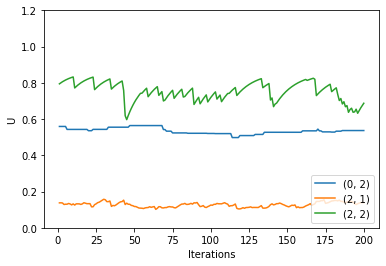

In [11]:
graph_utility_estimates(q_agent, sequential_decision_environment, 200, [(0,2),(2,1),(2,2)])